## Задача
В этом задании решается задача классификации. Надо классифицировать временные ряды на два класса. Решение содержит анализ предоставленных данных (EDA), процесс построения и проверки гипотез, генерацию признаков из обучающей выборки, обучение модели и предсказание. Модель реализована при помощи библиотеки tensorflow.keras.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
sns.set_theme(rc={'figure.figsize':(9, 6)})
pd.options.display.float_format = '{:20,.2f}'.format
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras.callbacks import History
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from joblib import dump

In [2]:
data = pd.read_parquet('train.parquet')

In [3]:
data.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.00
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.00
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.00
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.00
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [5]:
data.describe()

,id,label
count,"80,000.00","80,000.00"
mean,"50,107.89",0.28
std,"28,857.65",0.45
min,0.00,0.00
25%,"25,122.50",0.00
50%,"50,146.50",0.00
75%,"75,064.25",1.00
max,"99,999.00",1.00


## Работа с данными

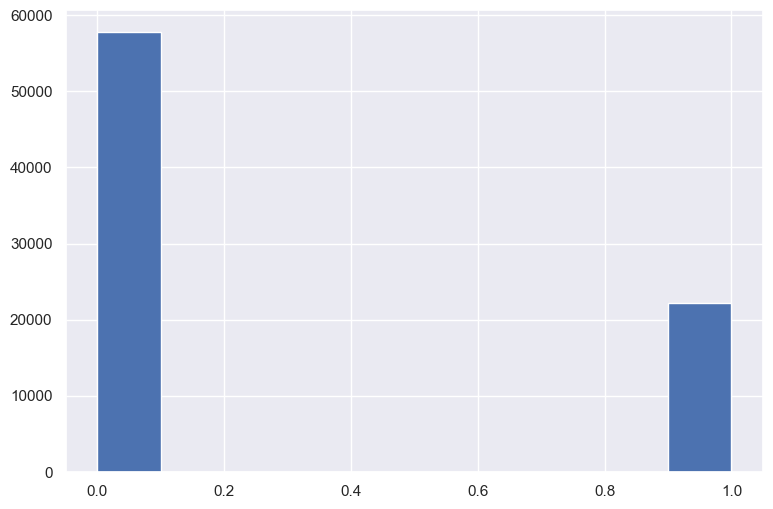

In [9]:
data['label'].hist();

In [10]:
data['label'].value_counts()

0.00    57820
1.00    22180
Name: label, dtype: int64

In [11]:
sum(data['id'].duplicated())

0

*Дубликатов в поле id в датасете нет. Однако обучающая выборка не сбалансирована, преобладают объекты с классом 0. В таком случае можно уравнять количество представителей классов путем удаления преобладающего или генерацией объектов класса-меньшинства. Также же можно при выборе гиперпараметров модели заранее учесть разный вес классов.*

#### Проверка средних

In [13]:
#class 1
np.mean(data.loc[data['id']==22769, 'values'].values[0])

-0.310776822615079

In [14]:
#class 1
np.mean(data.loc[data['id']==36908, 'values'].values[0])

-0.11255528082269704

In [15]:
#class 0
np.mean(data.loc[data['id']==19114, 'values'].values[0])

0.02370967741935484

In [16]:
#class 0
np.mean(data.loc[data['id']==94731, 'values'].values[0])

-0.07539682539682538

In [17]:
#class 0
np.mean(data.loc[data['id']==71474, 'values'].values[0])

0.16381818181818183

In [18]:
#class 1
np.mean(data.loc[data['id']==98870, 'values'].values[0])

-0.27463539733327336

*Возникла идея, что средние значений разных классов могут отличаться. Проверив несколько записей обоих классов, действительно, можно заметить, что среднее у объектов первого класса может быть ниже, чем у нулевого класса. Можно проверить эту гипотезу с помощью статистических тестов.*

### Заполнение пропусков

In [19]:
#проверим, есть ли внутри массивов пустые значения
n = 0
for array in data['values']:
    for x in array:
        if pd.isna(x):
            n+=1
n

4582

In [20]:
n = 0
for array in data['dates']:
    for x in array:
        if pd.isna(x):
            n+=1
n

0

In [21]:
#проверим, нет ли пустых массивов в принципе
n = 0
for array in data['values']:
    if array.any():
        pass
    else:
        n+=1
n

0

Заполним пустые значения средним по конкретному массиву.

In [22]:
data['values'] = data['values'].apply(lambda x: np.nan_to_num(x, np.nanmean(x)))

C:\Users\emil_\AppData\Local\Temp\ipykernel_1488\965633672.py:1: RuntimeWarning: Mean of empty slice
  data['values'] = data['values'].apply(lambda x: np.nan_to_num(x, np.nanmean(x)))


In [23]:
n = 0
for array in data['values']:
    for x in array:
        if pd.isna(x):
            n+=1
n

0

### Распаковка массивов

In [24]:
print(min(data['values'].apply(len)))
print(max(data['values'].apply(len)))

36
97


In [25]:
print(min([min(x) for x in data['values']]))
print(max([max(x) for x in data['values']]))

-7.95
9.54


In [26]:
print(min([min(x) for x in data['dates']]))
print(max([max(x) for x in data['dates']]))

2016-01-01
2024-01-01


Размерности массивов не равны, уравняем их добавлением синтетического значения в массивы меньших длин. 0 или -1 использовать не получится, так как они могут встречаться в реальных данных. Выберем значение 50.</br>
Также распакуем массивы в колонки, чтобы можно было проанализировать эти данные и затем передать модели.

In [27]:
def array_to_df(arrays, max_len):
    #создаем список списков с заполнением
    padded_arrays = [np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=(50)) for arr in arrays]
    return pd.DataFrame(padded_arrays)

In [28]:
def date_to_column(dates):
    min_date = [min(date) for date in dates]
    max_date = [max(date) for date in dates]
    return min_date, max_date

In [29]:
min_date, max_date = date_to_column(data['dates'])

In [30]:
len_max = max(data['values'].apply(len))
values_df = array_to_df(data['values'], len_max)

In [31]:
values_df.columns=['value_'+str(i+1) for i in range(len_max)]

In [32]:
values_df['id'] = data['id']
values_df['label'] = data['label']

## EDA

In [33]:
eda_df = data.explode(['dates', 'values'])

In [34]:
eda_df = eda_df.reset_index(drop=True)

In [35]:
eda_df['year'] = pd.to_datetime(eda_df['dates']).dt.year
eda_df['month'] = pd.to_datetime(eda_df['dates']).dt.month
eda_df = eda_df.drop(columns=['dates'])
eda_df.head()

,id,values,label,year,month
0,19114,-1.86,0.00,2016,1
1,19114,0.79,0.00,2016,2
2,19114,1.40,0.00,2016,3
3,19114,0.15,0.00,2016,4
4,19114,0.00,0.00,2016,5


In [36]:
eda_df['values'] = eda_df['values'].astype('float')

In [37]:
eda_df.describe()

,id,values,label,year,month
count,"5,155,412.00","5,155,412.00","5,155,412.00","5,155,412.00","5,155,412.00"
mean,"50,108.53",-0.03,0.27,"2,018.73",6.38
std,"28,865.00",1.22,0.45,1.86,3.44
min,0.00,-7.95,0.00,"2,016.00",1.00
25%,"25,105.75",-0.84,0.00,"2,017.00",3.00
50%,"50,149.00",-0.12,0.00,"2,019.00",6.00
75%,"75,067.00",0.76,1.00,"2,020.00",9.00
max,"99,999.00",9.54,1.00,"2,024.00",12.00


In [38]:
eda_df[eda_df['label']==0].describe()

,id,values,label,year,month
count,"3,743,582.00","3,743,582.00","3,743,582.00","3,743,582.00","3,743,582.00"
mean,"50,070.59",0.00,0.00,"2,018.75",6.38
std,"28,847.45",1.22,0.00,1.87,3.44
min,0.00,-7.48,0.00,"2,016.00",1.00
25%,"24,974.00",-0.81,0.00,"2,017.00",3.00
50%,"50,184.00",-0.08,0.00,"2,019.00",6.00
75%,"74,958.00",0.79,0.00,"2,020.00",9.00
max,"99,997.00",9.27,0.00,"2,024.00",12.00


In [39]:
eda_df[eda_df['label']==1].describe()

,id,values,label,year,month
count,"1,411,830.00","1,411,830.00","1,411,830.00","1,411,830.00","1,411,830.00"
mean,"50,209.12",-0.11,1.00,"2,018.69",6.39
std,"28,911.27",1.24,0.00,1.84,3.44
min,5.00,-7.95,1.00,"2,016.00",1.00
25%,"25,430.00",-0.91,1.00,"2,017.00",3.00
50%,"50,018.00",-0.20,1.00,"2,019.00",6.00
75%,"75,358.00",0.68,1.00,"2,020.00",9.00
max,"99,999.00",9.54,1.00,"2,024.00",12.00


Статистические показатели действительно отличаются. Стоит провести статистический тест, чтобы понять наверняка, есть ли между классами статистическая разница. Также видно, что в поле values есть выбросы, если считать таковыми значения, выходящие за "3 сигмы", причем отличаются они сильно. Чтобы не терять данные, заменим такие значения перцентилем.

### Замена выбросов

In [40]:
label_zero = eda_df[eda_df['label']==0]
label_one = eda_df[eda_df['label']==1]

In [41]:
lower_zero = label_zero['values'].quantile(0.01)
higher_zero = label_zero['values'].quantile(0.99)
lower_one = label_one['values'].quantile(0.01)
higher_one = label_one['values'].quantile(0.99)

In [42]:
values_df[values_df[values_df['label']==0].filter(regex='value')[values_df!=50]<lower_zero] = lower_zero
values_df[values_df[values_df['label']==0].filter(regex='value')[values_df!=50]>higher_zero] = higher_zero
values_df[values_df[values_df['label']==1].filter(regex='value')[values_df!=50]<lower_one] = lower_one
values_df[values_df[values_df['label']==1].filter(regex='value')[values_df!=50]>higher_one] = higher_one

#### eda dfs

In [43]:
label_zero.loc[label_zero['values']<lower_zero, 'values'] = lower_zero
label_zero.loc[label_zero['values']>higher_zero, 'values'] = higher_zero
label_one.loc[label_one['values']<lower_one, 'values'] = lower_one
label_one.loc[label_one['values']>higher_one, 'values'] = higher_one

In [44]:
label_zero.describe()

,id,values,label,year,month
count,"3,743,582.00","3,743,582.00","3,743,582.00","3,743,582.00","3,743,582.00"
mean,"50,070.59",-0.00,0.00,"2,018.75",6.38
std,"28,847.45",1.19,0.00,1.87,3.44
min,0.00,-2.72,0.00,"2,016.00",1.00
25%,"24,974.00",-0.81,0.00,"2,017.00",3.00
50%,"50,184.00",-0.08,0.00,"2,019.00",6.00
75%,"74,958.00",0.79,0.00,"2,020.00",9.00
max,"99,997.00",3.00,0.00,"2,024.00",12.00


In [45]:
label_one.describe()

,id,values,label,year,month
count,"1,411,830.00","1,411,830.00","1,411,830.00","1,411,830.00","1,411,830.00"
mean,"50,209.12",-0.11,1.00,"2,018.69",6.39
std,"28,911.27",1.20,0.00,1.84,3.44
min,5.00,-2.93,1.00,"2,016.00",1.00
25%,"25,430.00",-0.91,1.00,"2,017.00",3.00
50%,"50,018.00",-0.20,1.00,"2,019.00",6.00
75%,"75,358.00",0.68,1.00,"2,020.00",9.00
max,"99,999.00",2.98,1.00,"2,024.00",12.00


### Проверка гипотез

#### Гипотеза о статистической разности значений между классами

H0: нет статистической разницы;</br>
H1: статистическая разница есть.

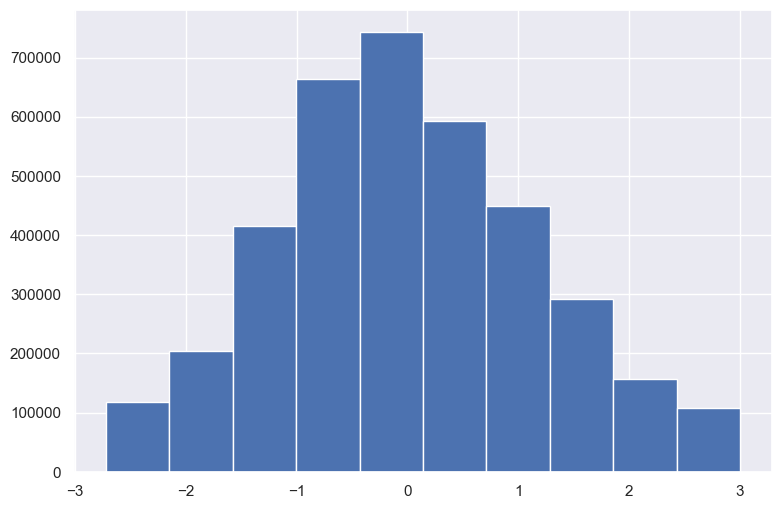

In [46]:
label_zero['values'].hist();

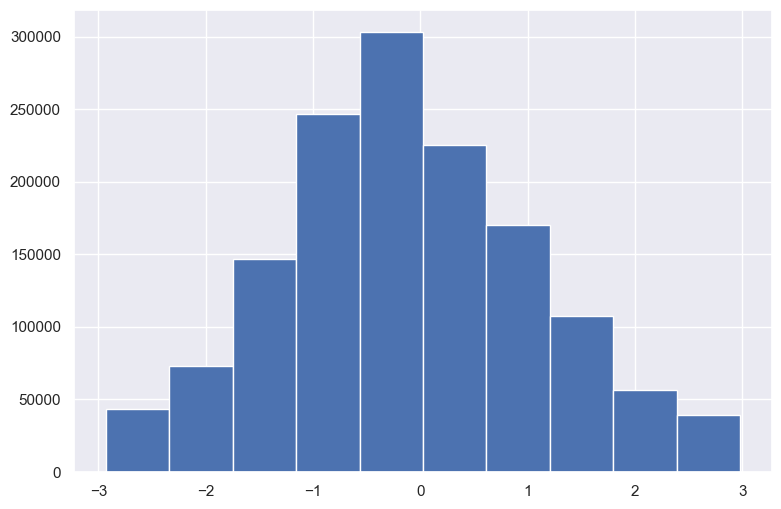

In [47]:
label_one['values'].hist();

Распределение близко к нормальному. Используем t-тест и тест Манна-Уитни.

#### t-тест

In [48]:
alpha = .05
result = st.ttest_ind(label_zero['values'], label_one['values'])
print('p-значение равно:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение равно: 0.0
Отвергаем нулевую гипотезу


#### Тест Манна-Уитни

In [49]:
result = st.mannwhitneyu(label_zero['values'], label_one['values'])
print('p-значение равно:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение равно: 0.0
Отвергаем нулевую гипотезу


Судя по всему, между классами действительно есть статистическая разница.

#### Гипотеза о разности длин последовательностей между классами

H0: нет статистической разницы;</br>
H1: статистическая разница есть.

In [50]:
len_zero = label_zero.groupby('id')['id'].count()
len_one = label_one.groupby('id')['id'].count()

#### t-тест

In [51]:
result = st.ttest_ind(len_zero, len_one)
print('p-значение равно:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение равно: 2.665074730572474e-19
Отвергаем нулевую гипотезу


#### Тест Манна-Уитни

In [52]:
result = st.mannwhitneyu(len_zero, len_one)
print('p-значение равно:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение равно: 3.742179382585712e-17
Отвергаем нулевую гипотезу


In [53]:
print(len_zero.mean())
print(len_one.mean())

64.74545140089934
63.653291253381425


Согласно тестам, классы также имеют разные длины последовательностей. Учтем это при сборке признаков.

### Анализ сезонности

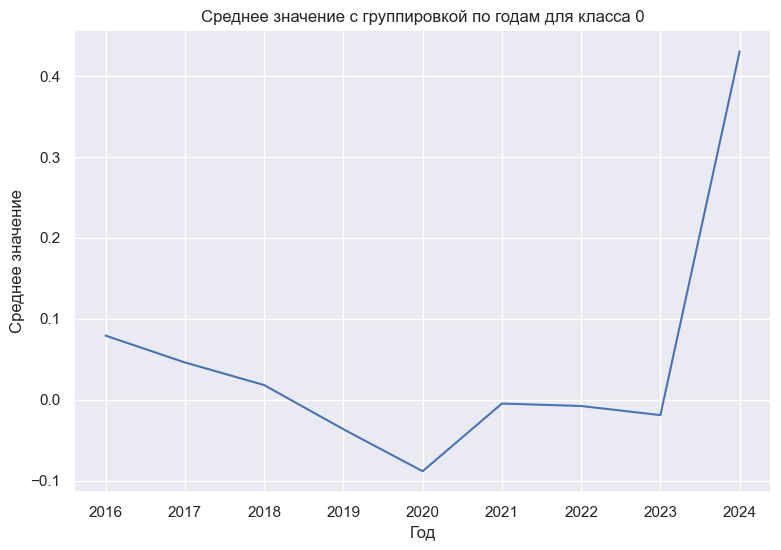

In [54]:
plt.plot(label_zero.groupby('year')['values'].mean())
plt.title('Среднее значение с группировкой по годам для класса 0')
plt.xlabel('Год')
plt.ylabel('Среднее значение');

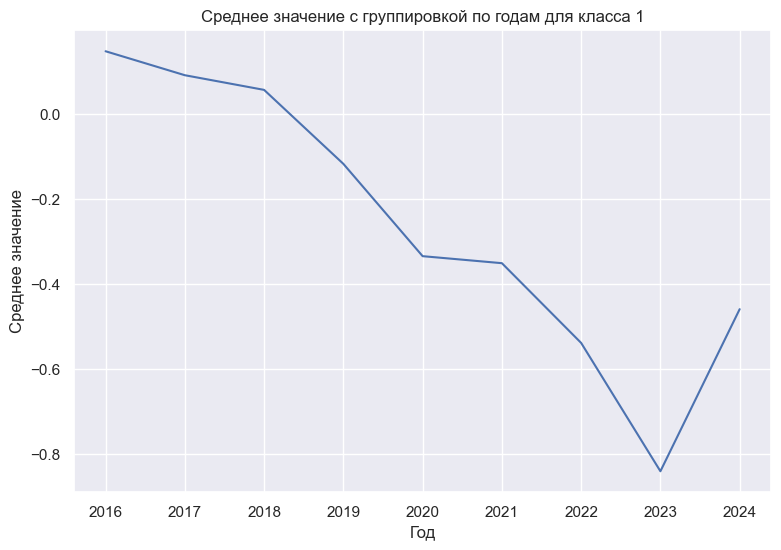

In [55]:
plt.plot(label_one.groupby('year')['values'].mean())
plt.title('Среднее значение с группировкой по годам для класса 1')
plt.xlabel('Год')
plt.ylabel('Среднее значение');

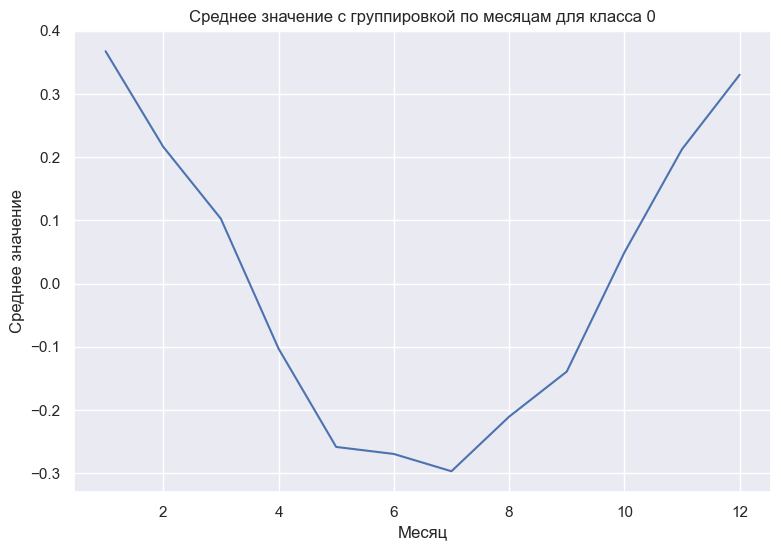

In [56]:
plt.plot(label_zero.groupby('month')['values'].mean())
plt.title('Среднее значение с группировкой по месяцам для класса 0')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение');

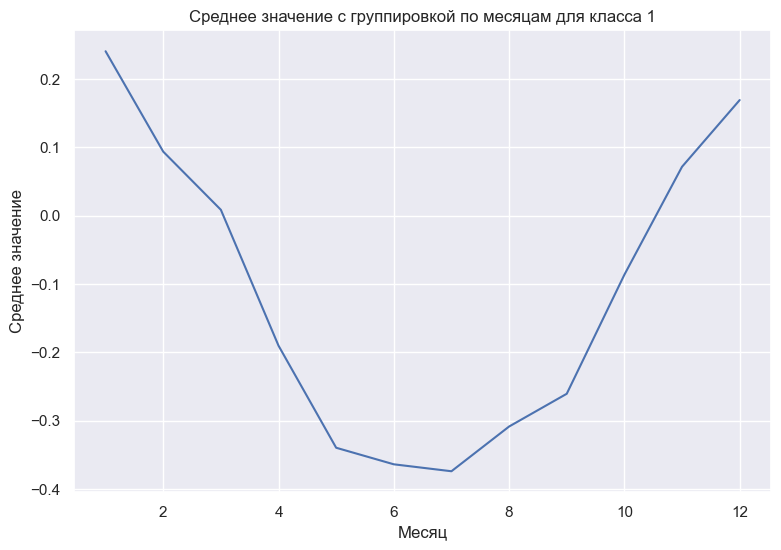

In [57]:
plt.plot(label_one.groupby('month')['values'].mean())
plt.title('Среднее значение с группировкой по месяцам для класса 1')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение');

По месяцам большой разницы между классами не видно, разве что сами значения в среднем чуть больше у класса 0, однако она явно прослеживается в разрезе по годам: классы сильно отличаются и в средних значениях, и в тренде, что дополнительно указывает на то, что между классами есть серьёзная разница.

#### Гистограмма плотности

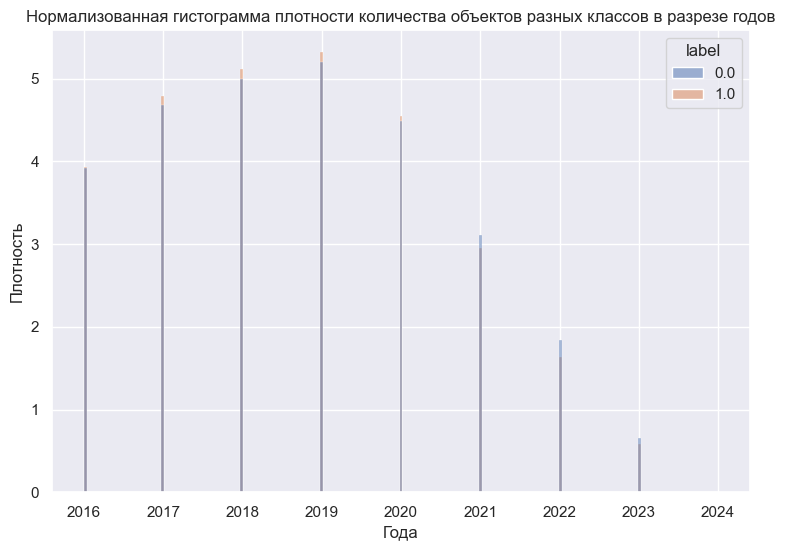

In [58]:
sns.histplot(eda_df, x='year', hue='label', stat='density', common_norm=False)
plt.title('Нормализованная гистограмма плотности количества объектов разных классов в разрезе годов')
plt.xlabel('Года')
plt.ylabel('Плотность');

По гистограмме трудно сделать вывод, что плотность двух классов в разрезе по годам как-то заметно отличается, хоть небольшая тенденция и есть: в ранние годы плотность у класса 1 выше, но затем класс 0 вырывается вперед. Но все-таки если разбить датасет по временной отметке, то пропорции классов в тренировочной и валидационной выборках будут примерно одинаковыми.

### Корреляция признаков с целевой переменной

In [59]:
corr_df = values_df[values_df!=50].corr()

In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(corr_df.loc[:, ['label']].sort_values(by='label'))

                        label
value_94                -0.36
value_95                -0.35
value_93                -0.35
value_92                -0.33
value_89                -0.32
value_91                -0.31
value_96                -0.30
value_90                -0.30
value_88                -0.29
value_87                -0.28
value_85                -0.28
value_86                -0.28
value_97                -0.26
value_84                -0.26
value_83                -0.25
value_81                -0.23
value_82                -0.23
value_80                -0.20
value_76                -0.20
value_74                -0.19
value_78                -0.19
value_77                -0.19
value_72                -0.19
value_73                -0.19
value_75                -0.19
value_79                -0.19
value_71                -0.18
value_70                -0.17
value_69                -0.16
value_68                -0.15
value_58                -0.14
value_60                -0.14
value_57  

Интересный момент: более поздние признаки сильнее коррелируют с целевой переменной, чем ранние. Возможно, это связано с тем, что более поздних признаков просто меньше и еще получается как-то прослеживать линейную связь.

## Подготовка датасетов для обучения

In [61]:
mean = values_df.drop(columns=['label', 'id'])[values_df!=50].mean(axis=1)
std = values_df.drop(columns=['label', 'id'])[values_df!=50].std(axis=1)
median = values_df.drop(columns=['label', 'id'])[values_df!=50].median(axis=1)

new_df = pd.DataFrame()
new_df['mean'] = mean
new_df['std'] = std
new_df['median'] = median
new_df['min_date'] = min_date
new_df['max_date'] = max_date
new_df['label'] = data['label']

In [62]:
new_df.head()

,mean,std,median,min_date,max_date,label
0,0.05,1.23,-0.11,2016-01-01,2021-02-01,0.00
1,-0.28,1.52,-0.27,2016-05-01,2020-01-01,1.00
2,-0.05,1.08,-0.15,2017-03-01,2021-02-01,0.00
3,-0.13,1.17,-0.34,2016-01-01,2019-12-01,0.00
4,-0.27,1.28,-0.47,2016-01-01,2020-08-01,0.00


In [63]:
#кодирование даты
new_df['left_year'] = pd.to_datetime(new_df['min_date']).dt.year
new_df['left_month'] = pd.to_datetime(new_df['min_date']).dt.month
new_df['right_year'] = pd.to_datetime(new_df['max_date']).dt.year
new_df['right_month'] = pd.to_datetime(new_df['max_date']).dt.month

new_df['length'] = ((new_df['max_date'] - new_df['min_date']) / np.timedelta64(1, 'M')).astype(int)

years_count = (max(new_df['right_year']) - min(new_df['left_year'])) + 1
new_df['left_year'] = years_count - (max(new_df['right_year']) - new_df['left_year'])
new_df['right_year'] = years_count - (max(new_df['right_year']) - new_df['right_year'])

In [64]:
new_df = new_df.drop(columns=['min_date', 'max_date'])

In [65]:
new_df = new_df.sort_values(by=['left_year', 'left_month', 'right_year', 'right_month'])

In [66]:
new_df.head()

,mean,std,median,label,left_year,left_month,right_year,right_month,length
3,-0.13,1.17,-0.34,0.00,1,1,4,12,46
215,-0.21,1.23,-0.27,1.00,1,1,4,12,46
226,0.02,1.10,-0.29,0.00,1,1,4,12,46
274,0.01,1.30,0.21,0.00,1,1,4,12,46
281,-0.11,1.22,0.08,0.00,1,1,4,12,46


In [67]:
X_train = new_df[:60000].drop(columns=['label'])
y_train = new_df[:60000]['label']

# X_val = new_df[40000:60000].drop(columns=['label'])
# y_val = new_df[40000:60000]['label']

X_test = new_df[60000:80000].drop(columns=['label'])
y_test = new_df[60000:80000]['label']

In [68]:
scaler = StandardScaler()

X_train_st = scaler.fit_transform(X_train)
#X_val_st = scaler.transform(X_val)
X_test_st = scaler.transform(X_test)

dump(scaler, 'std_scaler.bin', compress=True)

In [69]:
print(X_train_st.shape)
print(y_train.shape)
# print(X_val_st.shape)
# print(y_val.shape)
print(X_test_st.shape)
print(y_test.shape)

(60000, 8)
(60000,)
(20000, 8)
(20000,)


In [70]:
class_weight = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [71]:
class_weight = {0: class_weight[0], 1: class_weight[1]}

## Сборка модели

Так как данные являются последовательностями данных, наиболее подходящая архитектура - LSTM. Однако в процессе проведение тестов оказалось, что перцептрон показывает лучшие результаты. Для реализации использована библиотека tensorflow.keras, одна из самых популярных и богатых библиотек машинного обучения. Также встроенные инструменты, такие как маскирующий слой для игнорирования определенных значений и задание весов каждому классу целевой переменной для несбалансированных выборок поможет с имеющимся датасетом. Кроме того, получилось довольно много признаков, корреляция между которыми не исследована, поэтому дополнительно понадобится добавить регуляризацию.

In [72]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    keras.callbacks.ModelCheckpoint('./checkpoint/modelcp.keras', monitor='val_loss', save_best_only=True)
]

In [73]:
model = keras.Sequential([
    layers.Dense(
        128,
        activation='relu',
    ),
    layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.1)
    ),
    layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC()]
)

model.fit(
    X_train_st, 
    y_train, 
    epochs=20, 
    validation_data=(X_test_st, y_test),
    class_weight=class_weight,
    callbacks=callbacks,
    batch_size=16
);

Epoch 1/20
3750/3750 [==============================] - 8s 2ms/step - loss: 0.6698 - auc: 0.8093 - val_loss: 0.5425 - val_auc: 0.8202
Epoch 2/20
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5349 - auc: 0.8172 - val_loss: 0.6966 - val_auc: 0.8251
Epoch 3/20
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5314 - auc: 0.8192 - val_loss: 0.6306 - val_auc: 0.8337
Epoch 4/20
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5304 - auc: 0.8194 - val_loss: 0.5803 - val_auc: 0.8227


In [74]:
model.evaluate(X_test_st, y_test)

625/625 [==============================] - 1s 1ms/step - loss: 0.5803 - auc: 0.8227


[0.580308198928833, 0.8226550817489624]

In [75]:
model.save('mlp_model.h5')